In [2]:
import numpy as np
import GPyOpt


from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn import metrics
from scipy.stats import uniform
from sklearn import linear_model, metrics
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from xgboost import XGBRegressor


In [3]:
X, y = datasets.load_diabetes(return_X_y=True)

In [4]:
logistic = XGBRegressor()


baseline = cross_val_score(logistic, X, y, scoring='').mean()
print(baseline)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [5]:
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(logistic, param_distributions=param_dist, 
                        scoring='precision', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, y);

 /home/eoin/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [6]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

Baseline neg. MSE = {baseline:.2f}
Random search neg. MSE = {y_rs[-1]:.2f}
Bayesian optimization neg. MSE = {y_bo[-1]:.2f}


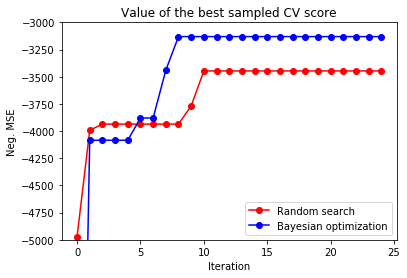

In [7]:
import matplotlib.pyplot as plt

y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print('Baseline neg. MSE = {baseline:.2f}')
print('Random search neg. MSE = {y_rs[-1]:.2f}')
print('Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();